In [1]:
# La Clase Model para manejar los agentes y la clase Agent para definir un agente
from mesa import Agent, Model

# En cada celda, puede haber varios agentes con MultiGrid
from mesa.space import MultiGrid

# Activaremos a todos los agentes al mismo tiempo 
from mesa.time import SimultaneousActivation

# Recuperar informacion del modelo
from mesa.datacollection import DataCollector

# Matplotlib se usara para hacer una animcacion de mi modelo
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

import numpy as np
import pandas as pd

# Definimos otros paquetes a utilizar
import time
import datetime
import random

In [2]:
def get_current_grid(model): 
    grid = np.zeros((model.agents_grid.height, model.agents_grid.width))
    
    for row in range(len(model.boxes_grid)):
        for col in range(len(model.boxes_grid)):
            grid[row][col] = model.boxes_grid[row][col]
    
    for (content, row, col) in model.agents_grid.coord_iter():
        for agent in content:
            grid[row][col] += 10 + agent.boxes_carrying
#         grid[row][col] += len(content)
    
    return grid

def is_valid_cell(model, row, col):
        return (row >= 0 and row < model.rows and
               col >= 0 and col < model.columns)

In [3]:
class AlmacenModel(Model): 
    def __init__(self, rows = 20, columns = 20, percentage_boxes = 0.5, num_robots = 5):
        self.num_robots = num_robots
        self.rows = rows
        self.columns = columns
        self.boxes_grid = np.zeros((rows, columns))
        self.agents_grid = MultiGrid(rows, columns, False)
        self.num_boxes = rows * columns * percentage_boxes
        self.agents_moves = 0
        self.goal_stacks = int(self.num_boxes / 5)
        self.completed_stacks = 0
        self.next_stack = [0, 0]    # (col, row) where agents should place their boxes
        self.schedule = SimultaneousActivation(self)
        
        self.place_boxes(self.num_boxes)
        self.place_robots(self.num_robots)
        self.datacollector = DataCollector(model_reporters={"Grid" : get_current_grid})
    
    def place_boxes(self, num_boxes):
        boxes_placed = 0

        while boxes_placed < num_boxes:
            random_row = np.random.randint(0, self.rows)
            random_column = np.random.randint(0, self.columns)

            if self.boxes_grid[random_row][random_column] == 0:
                self.boxes_grid[random_row][random_column] = 1
                boxes_placed += 1
    
    def place_robots(self, num_robots):
        for robot_id in range(num_robots):
            agent = RobotAgent(robot_id, self)
            (x, y) = self.agents_grid.find_empty()
            self.agents_grid.place_agent(agent, (x, y))
            self.schedule.add(agent)
    
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        
    def get_completed_stacks(self):
        return ((self.next_stack[0] * self.columns) + self.next_stack[1])
    
    def print_boxes(self):
        for i in range(self.rows):
            for j in range(self.columns):
                print(str(self.boxes_grid[i][j]) + ' ')
            print("\n")

In [4]:
class RobotAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.is_travelling = False
        self.boxes_carrying = 0
        self.max_boxes_to_carry = 5
    
    def reached_goal(self):
        return (self.pos[0] == self.model.next_stack[0] and 
                self.pos[1] == self.model.next_stack[1])
    
    def pick_up_boxes(self):
        nextRows = [0, -1, 0, 1, 0]
        nextCols = [0, 0, 1, 0, -1]
        
        row = self.pos[0]
        col = self.pos[1]
        
        for i in range(len(nextRows)):
            nextRow = row + nextRows[i]
            nextCol = col + nextCols[i]
            
            if (is_valid_cell(self.model, nextRow, nextCol) and
                self.is_valid_box(nextRow, nextCol)):
                while (self.model.boxes_grid[nextRow][nextCol] > 0 and 
                       self.boxes_carrying < self.max_boxes_to_carry): 
                    self.boxes_carrying += 1
                    self.model.boxes_grid[nextRow][nextCol] -= 1
    
    def move_to_goal(self):  
        if self.pos[0] > self.model.next_stack[0]:
            self.model.agents_grid.move_agent(self, (self.pos[0] - 1, self.pos[1]))
        elif self.pos[0] < self.model.next_stack[0]:
            self.model.agents_grid.move_agent(self, (self.pos[0] + 1, self.pos[1]))
        elif self.pos[1] > self.model.next_stack[1]:
            self.model.agents_grid.move_agent(self, (self.pos[0], self.pos[1] - 1))
        elif self.pos[1] < self.model.next_stack[1]:
            self.model.agents_grid.move_agent(self, (self.pos[0], self.pos[1] + 1))
        
        self.model.agents_moves += 1
            
        return
    
    def place_boxes_in_stack(self):
        while self.boxes_carrying > 0:
            row = self.pos[0] 
            col = self.pos[1]
            
            if self.model.boxes_grid[row][col] < 5:
                self.model.boxes_grid[row][col] += 1
                self.boxes_carrying -= 1
                
                if (self.boxes_carrying == 0 and self.model.boxes_grid[row][col] == 5 or 
                   self.model.boxes_grid[row][col] == 5):
                    self.model.completed_stacks += 1
                    
            else: 
                if is_valid_cell(self.model, row, col + 1):
                    self.model.next_stack = [row, col + 1]
                    self.model.agents_grid.move_agent(self, (row, col + 1))
                elif is_valid_cell(self.model, row + 1, 0):
                    self.model.next_stack = [row + 1, 0]
                    self.model.agents_grid.move_agent(self, (row + 1, 0))

                self.model.agents_moves += 1

        return
    
    def get_random_valid_cell(self):
        random_row = 0
        random_col = 0
        
        while (random_row < self.model.next_stack[0] or 
               (random_col <= self.model.next_stack[1] and random_row <= self.model.next_stack[0])):
            random_row = np.random.randint(0, self.model.rows)
            random_col = np.random.randint(0, self.model.columns)
            
        return [random_row, random_col]
    
    def is_valid_box(self, row, col):
        return (row > self.model.next_stack[0] or 
               (col > self.model.next_stack[1] 
                and row >= self.model.next_stack[0]))
    
    def step(self):
        row = self.pos[0]
        col = self.pos[1]
        
        if self.reached_goal():
            self.place_boxes_in_stack()
            new_pos = self.get_random_valid_cell()
            self.model.agents_grid.move_agent(self, (new_pos[0], new_pos[1]))
            self.is_travelling = False
        else:
            if (self.boxes_carrying < self.max_boxes_to_carry and
                self.is_valid_box(self.pos[0], self.pos[1])):
                self.pick_up_boxes()
                
            if self.boxes_carrying == 0:
                new_pos = self.get_random_valid_cell()
                self.model.agents_grid.move_agent(self, (new_pos[0], new_pos[1]))
            else:
                if self.is_travelling:
                    self.move_to_goal()
                else:
                    self.is_travelling = True
                    
        return

In [5]:
ROWS = 20
COLUMNS = 20
PERCENTAGE_BOXES = 0.5
NUM_ROBOTS = 5
MAX_TIME = 500

almacenModel = AlmacenModel(ROWS, COLUMNS, PERCENTAGE_BOXES, NUM_ROBOTS)

time = 0
while time < MAX_TIME and almacenModel.completed_stacks < almacenModel.goal_stacks:
    almacenModel.step()
    time += 1

In [6]:
results = ""
results += "El numero de movimientos realizados fue: " + str(almacenModel.agents_moves) + "\n"
results += "Tiempo maximo: " + str(MAX_TIME) + "\n"
results += "Tiempo tomado: " + str(time) + "\n"

In [7]:
all_grid = almacenModel.datacollector.get_model_vars_dataframe()

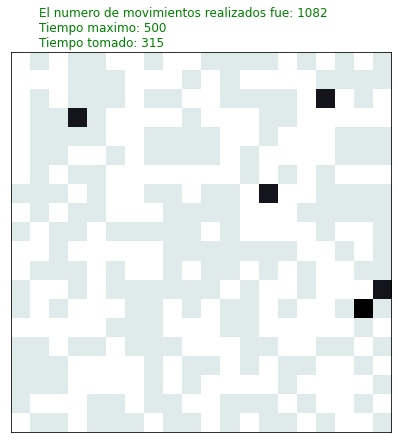

In [8]:
fig, axs = plt.subplots(figsize=(7,7))
axs.set_xticks([])
axs.set_yticks([])
font = {'color': 'g', 
        'size': 12,
       }
plt.text(1, 0, results, fontdict = font)

patch = plt.imshow(all_grid.iloc[0][0], cmap = plt.cm.bone_r)

def animate(i):
    patch.set_data(all_grid.iloc[i][0])
    
anim = animation.FuncAnimation(fig, animate, frames = time)

In [9]:
anim